<a href="https://colab.research.google.com/github/meer-1/Deep-learning-projects/blob/main/M21MA207_Deep_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/10], Train Loss: 0.2489, Validation Loss: 0.0991, Test Accuracy: 0.9767
Epoch [2/10], Train Loss: 0.0781, Validation Loss: 0.0704, Test Accuracy: 0.9833
Epoch [3/10], Train Loss: 0.0604, Validation Loss: 0.0601, Test Accuracy: 0.9856
Epoch [4/10], Train Loss: 0.0517, Validation Loss: 0.0505, Test Accuracy: 0.9870
Epoch [5/10], Train Loss: 0.0447, Validation Loss: 0.0453, Test Accuracy: 0.9878
Epoch [6/10], Train Loss: 0.0398, Validation Loss: 0.0390, Test Accuracy: 0.9879
Epoch [7/10], Train Loss: 0.0370, Validation Loss: 0.0377, Test Accuracy: 0.9879
Epoch [8/10], Train Loss: 0.0353, Validation Loss: 0.0339, Test Accuracy: 0.9890
Epoch [9/10], Train Loss: 0.0327, Validation Loss: 0.0321, Test Accuracy: 0.9888
Epoch [10/10], Train Loss: 0.0301, Validation Loss: 0.0301, Test Accuracy: 0.9891


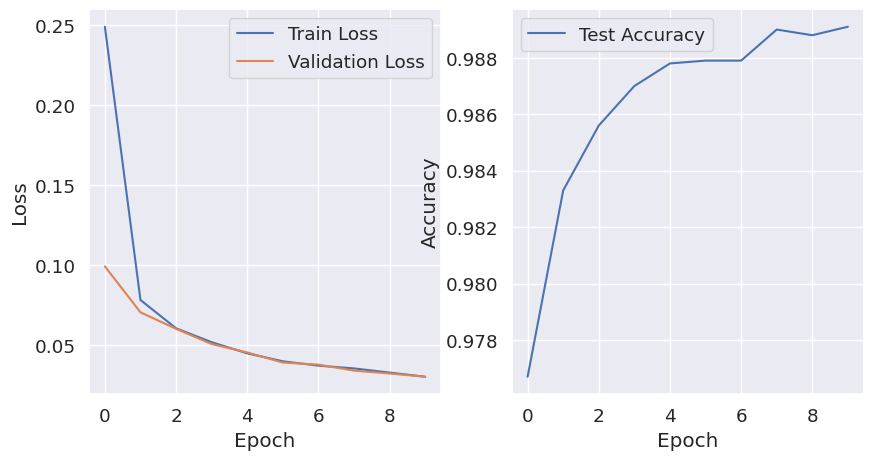

Confusion Matrix:
[[ 975    1    1    0    0    1    0    1    1    0]
 [   0 1133    0    1    0    0    1    0    0    0]
 [   1    7 1019    0    0    0    1    3    1    0]
 [   0    0    1 1006    0    2    0    1    0    0]
 [   1    2    0    0  976    0    1    0    1    1]
 [   0    0    0    6    0  882    1    1    1    1]
 [   4    4    0    0    1    4  943    0    2    0]
 [   0    8    5    0    0    0    0 1010    1    4]
 [   1    1    1    3    1    2    0    0  960    5]
 [   0    4    0    1    9    4    0    4    0  987]]
Total parameters: 5750, Trainable parameters: 5750


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import struct
import gzip
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
# Set the random seed for reproducibility

torch.manual_seed(4)
np.random.seed(4)

# Load the MNIST data
def load_mnist_data(file_path):
    with gzip.open(file_path, 'rb') as file:
        content = file.read()
    magic_number, num_items = struct.unpack('>II', content[:8])
    if magic_number == 2051:  # Image data
        num_rows, num_cols = struct.unpack('>II', content[8:16])
        image_size = num_rows * num_cols
        image_data = np.frombuffer(content[16:], dtype=np.uint8).reshape((num_items, 1, num_rows, num_cols))
        return image_data
    elif magic_number == 2049:  # Label data
        label_data = np.frombuffer(content[8:], dtype=np.uint8)
        return label_data
    else:
        raise ValueError("Unknown file format")

# Specify file paths
train_images_path = '/content/drive/MyDrive/MNIST/MNIST/train-images-idx3-ubyte.gz'
train_labels_path = '/content/drive/MyDrive/MNIST/MNIST/train-labels-idx1-ubyte.gz'
test_images_path = '/content/drive/MyDrive/MNIST/MNIST/t10k-images-idx3-ubyte.gz'
test_labels_path = '/content/drive/MyDrive/MNIST/MNIST/t10k-labels-idx1-ubyte.gz'

# Load MNIST data
train_data = load_mnist_data(train_images_path)
train_labels = load_mnist_data(train_labels_path)
test_data = load_mnist_data(test_images_path)
test_labels = load_mnist_data(test_labels_path)

# Convert data to PyTorch tensors
train_image_tensor = torch.tensor(train_data/255, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_image_tensor = torch.tensor(test_data/255, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create datasets and data loaders
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

# Set batch size based on conditions  207%3==0
roll_number = 207
batch_size = 16


# Split the training data into training and validation sets
val_split = 0.2
total_train_samples = len(train_image_tensor)
val_size = int(val_split * total_train_samples)
train_size = total_train_samples - val_size

indices = np.random.permutation(total_train_samples)
train_indices, val_indices = indices[:train_size], indices[train_size:]

train_dataset = CustomDataset(train_image_tensor[train_indices], train_labels_tensor[train_indices])
val_dataset = CustomDataset(train_image_tensor[val_indices], train_labels_tensor[val_indices])
test_dataset = CustomDataset(test_image_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, input_channels=1):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=7, stride=1, padding=3)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)

        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)

        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.fc_input_size = 4 * 6 * 6  # Update based on the size of the output from the last conv layer
        self.fc = nn.Linear(self.fc_input_size, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Function to train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Function to test the model
def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['data'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = correct / total
    return accuracy, confusion_matrix(all_labels, all_preds)

# Function to plot accuracy and loss per epoch
def plot_metrics(train_losses, val_losses, test_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = CNNModel(input_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 10
train_losses = []
val_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validation
    val_loss = train(model, val_loader, criterion, optimizer, device)
    val_losses.append(val_loss)

    # Test
    accuracy, _ = test(model, test_loader, criterion, device)
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Test Accuracy: {accuracy:.4f}')

# Plotting metrics
plot_metrics(train_losses, val_losses, test_accuracies)

# Print confusion matrix
_, confusion_mat = test(model, test_loader, criterion, device)


conf_matrix = np.array(confusion_mat)






print("Confusion Matrix:")
print(confusion_mat)

# Report total trainable and non-trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}, Trainable parameters: {trainable_params}")


#4Class classification


Epoch [1/10], Train Loss: 0.1527, Validation Loss: 0.0716, Test Accuracy: 0.9824
Epoch [2/10], Train Loss: 0.0521, Validation Loss: 0.0461, Test Accuracy: 0.9840
Epoch [3/10], Train Loss: 0.0400, Validation Loss: 0.0366, Test Accuracy: 0.9876
Epoch [4/10], Train Loss: 0.0343, Validation Loss: 0.0296, Test Accuracy: 0.9908
Epoch [5/10], Train Loss: 0.0300, Validation Loss: 0.0269, Test Accuracy: 0.9916
Epoch [6/10], Train Loss: 0.0270, Validation Loss: 0.0245, Test Accuracy: 0.9912
Epoch [7/10], Train Loss: 0.0248, Validation Loss: 0.0240, Test Accuracy: 0.9914
Epoch [8/10], Train Loss: 0.0237, Validation Loss: 0.0224, Test Accuracy: 0.9919
Epoch [9/10], Train Loss: 0.0220, Validation Loss: 0.0203, Test Accuracy: 0.9916
Epoch [10/10], Train Loss: 0.0214, Validation Loss: 0.0195, Test Accuracy: 0.9918


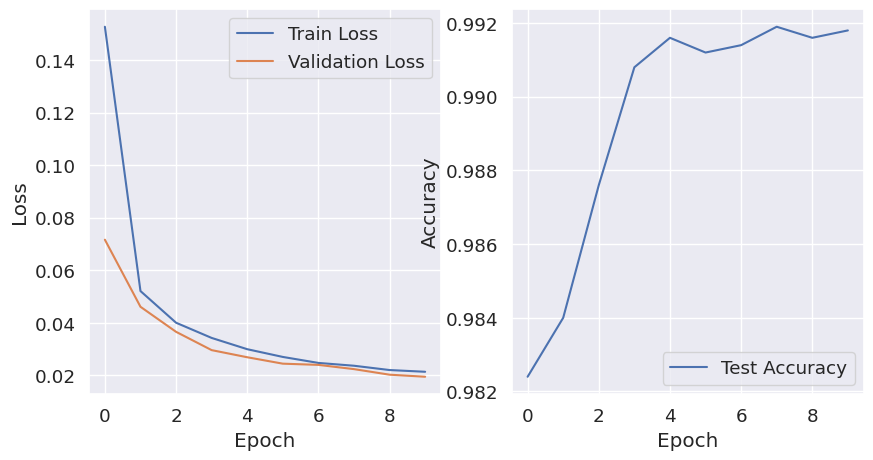

Confusion Matrix:
[[1909    5   22    2]
 [   1 2145   15    2]
 [   4    9 3890    5]
 [   0    3   14 1974]]
Total parameters: 4880, Trainable parameters: 4880


In [ ]:



# Define new class definitions
class_mapping = {0: 0, 6: 0, 1: 1, 7: 1, 2: 2, 3: 2, 8: 2, 5: 2, 4: 3, 9: 3}

# Modify labels according to new class definitions
train_labels = np.array([class_mapping[label] for label in train_labels])
test_labels = np.array([class_mapping[label] for label in test_labels])

# Convert data to PyTorch tensors
train_image_tensor = torch.tensor(train_data/255, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_image_tensor = torch.tensor(test_data/255, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)


# Set batch size based on conditions
roll_number = 207
batch_size = 16


# Split the training data into training and validation sets
val_split = 0.2
total_train_samples = len(train_image_tensor)
val_size = int(val_split * total_train_samples)
train_size = total_train_samples - val_size

indices = np.random.permutation(total_train_samples)
train_indices, val_indices = indices[:train_size], indices[train_size:]

train_dataset = CustomDataset(train_image_tensor[train_indices], train_labels_tensor[train_indices])
val_dataset = CustomDataset(train_image_tensor[val_indices], train_labels_tensor[val_indices])
test_dataset = CustomDataset(test_image_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class CNNModel2(nn.Module):
    def __init__(self, input_channels=1):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=7, stride=1, padding=3)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)

        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)

        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.fc_input_size = 4 * 6 * 6  # Update based on the size of the output from the last conv layer
        self.fc = nn.Linear(self.fc_input_size, 4)  # 4 classes for the new problem

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = CNNModel2(input_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 10
train_losses = []
val_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validation
    val_loss = train(model, val_loader, criterion, optimizer, device)
    val_losses.append(val_loss)

    # Test
    accuracy, _ = test(model, test_loader, criterion, device)
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Test Accuracy: {accuracy:.4f}')

# Plotting metrics
plot_metrics(train_losses, val_losses, test_accuracies)

# Print confusion matrix
_, confusion_mat = test(model, test_loader, criterion, device)



conf_matrix = np.array(confusion_mat)




print("Confusion Matrix:")
print(confusion_mat)

# Report total trainable and non-trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}, Trainable parameters: {trainable_params}")
